In [1]:
import sys
from time import time

sys.path.append('../electrode')

import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as ct

from oned_grid import System_grid

In [2]:
# Define parameters
o = 34.1e6*2*np.pi # rf frequency
m = 174*ct.atomic_mass # ion mass
e = 1*ct.elementary_charge # ion charge
l = 1e-6    # length scale factor
# strength of dc and rf potential
Tperiod = 1.
U0, V0 = m/e*(2*np.pi/Tperiod)**2, 0.
print('U0: %f\nV0: %f'%(U0,V0))

# analytic solution of classical harmonic oscillator
def exact_x(t,x0,v0,omega):
    # initial time t0=0.
    return x0*np.cos(omega*t)+v0*omega*np.sin(omega*t)

def exact_v(t,x0,v0,omega):
    # initial time t0=0.
    return -omega*x0*np.sin(omega*t)+v0*omega**2*np.cos(omega*t)

# generate discrete potential
def dc_func(y):
    return 1./2.*y*y

def rf_func(y):
    return 0.*y

U0: 0.000071
V0: 0.000000


In [3]:
# discrete grid and system class
grid = np.linspace(-2,2,5)#*l
sim = System_grid(grid)
sim.rf_scale(e/m,o,l)
sim.dc, sim.rf = U0, 0.
sim.generate_pot(dc_func,'dc')
sim.generate_pot(rf_func,'rf')
Tperiod = 2*np.pi/np.sqrt(e*U0/m)
omega = 2*np.pi/Tperiod
Tperiod, omega

(1.0, 6.283185307179586)

Text(0,0.5,'Potential/V')

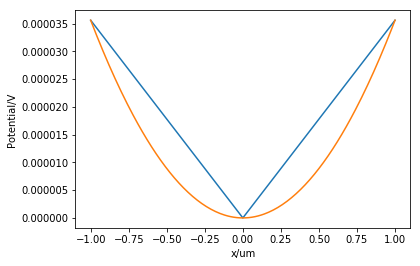

In [4]:
# plot quadratic potential interpolated from potential on grid
xend, step = 1., 201
pos = np.linspace(-xend,xend,step)#*l
pot = []
for pt in pos:
    pot.append(sim.potential(pt,deri=0,typ='dc'))
fig, ax = plt.subplots()
ax.plot(pos,pot)

# plot analytic quadratic potential
ax.plot(pos,sim.analytic(pos,deri=0))
ax.set_xlabel('x/um')
ax.set_ylabel('Potential/V')

/home/wwc/anaconda3/envs/ele36/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


(-0.0020569457952796903,
 -0.00010305355016061816,
 -0.001432611036137953,
 1.9234118493563762e-07)

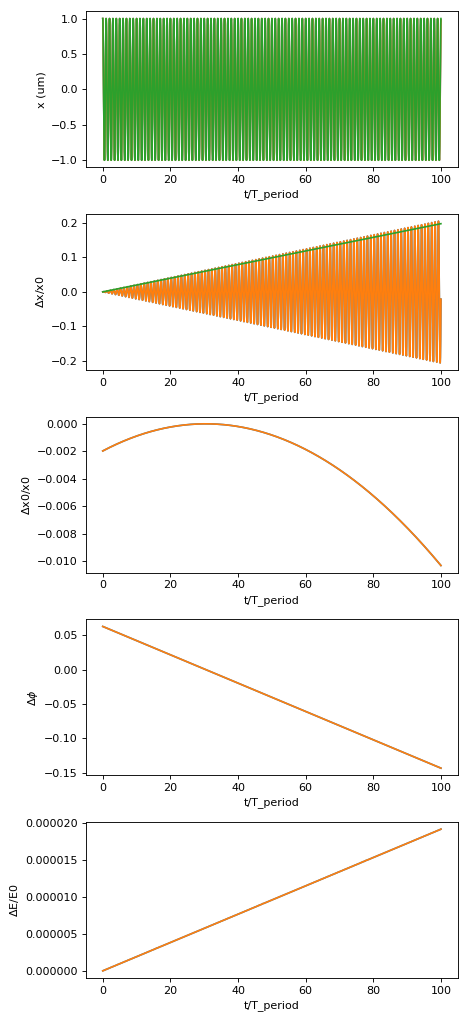

In [7]:
# trajectory euler simulation
dt = np.double(1e-2*Tperiod)
nperiod = 100
order = 3
x0, v0 = 1., 0.
phi0 = 0.
E0 = e*sim.analytic(x0,deri=0)
ncycle, nreport = int(nperiod*Tperiod/dt), 1
t_eval = np.linspace(0.,dt*ncycle,ncycle/nreport+1)
trja = exact_x(t_eval,x0,v0,omega)
# position x(t)
trj1, trj2 = [x0], [x0]
# amplitude ratio Δx0/x0
atrj1, atrj2 = [np.nan], [np.nan]
# phase diff Δφ
ptrj1, ptrj2 = [np.nan], [np.nan]
# energy ratio ΔE/E0
etrj1, etrj2 = [0.], [0.]
tr1 = sim.trajectory_euler(x0=x0,v0=v0,qoverm=e/m,dt=dt,nsteps=1,mode='analytic',itern=order)
tr2 = sim.trajectory_euler(x0=x0,v0=v0,qoverm=e/m,dt=dt,nsteps=1,mode='discrete',itern=order)
for i in range(ncycle):
    xnew1, xnew2 = next(tr1), next(tr2)
    if i%nreport == 0:
        phase = omega*i*dt
        # position x(t)
        trj1.append(xnew1[1])
        trj2.append(xnew2[1])
        # Δx, Δv
        deltax1 = xnew1[1]-exact_x(i*dt,x0,v0,omega)
        deltax2 = xnew2[1]-exact_x(i*dt,x0,v0,omega)
        deltav1 = xnew1[2]-exact_v(i*dt,x0,v0,omega)
        deltav2 = xnew2[2]-exact_v(i*dt,x0,v0,omega)
        # amplitude ratio Δx0/x0
        atrj1.append(deltax1*np.cos(phase)-deltav1/omega*np.sin(phase))
        atrj2.append(deltax2*np.cos(phase)-deltav2/omega*np.sin(phase))
        # phase diff Δφ
        ptrj1.append(-(deltax1*np.sin(phase)+deltav1/omega*np.cos(phase))/x0)
        ptrj2.append(-(deltax2*np.sin(phase)+deltav2/omega*np.cos(phase))/x0)
        # energy ratio ΔE/E0
        etrj1.append((e*sim.analytic(xnew1[1],deri=0)+1./2*m*xnew1[2]**2-E0)/E0)
        etrj2.append((e*sim.analytic(xnew2[1],deri=0)+1./2*m*xnew2[2]**2-E0)/E0)
# position x(t)
trj1, trj2 = np.array(trj1),np.array(trj2)
# Δx
dtrja = (omega*dt)**2*t_eval/2/x0
dtrj1, dtrj2 = (trj1-trja)/x0, (trj2-trja)/x0
dtrj_slope = max(dtrj1,key=abs)/nperiod
# amplitude ratio Δx0/x0
atrj1, atrj2 = np.array(atrj1)/x0, np.array(atrj2)/x0
atrj_slope = max(np.nanmax(atrj1),np.nanmin(atrj1),key=abs)/nperiod
# phase diff Δφ
ptrj1, ptrj2 = np.array(ptrj1), np.array(ptrj2)
ptrj_slope = max(np.nanmax(ptrj1),np.nanmin(ptrj1),key=abs)/nperiod
# energy ratio ΔE/E0
etrj1, etrj2 = np.array(etrj1), np.array(etrj2)
etrj_slope = max(etrj1,key=abs)/nperiod
        
fig, ax = plt.subplots(5,1,gridspec_kw={'hspace':0.3},figsize=(6,16),dpi=80)
ax[0].plot(t_eval/Tperiod,trj1,t_eval/Tperiod,trj2,t_eval/Tperiod,trja)
ax[1].plot(t_eval/Tperiod,dtrj1,t_eval/Tperiod,dtrj2,t_eval/Tperiod,dtrja)
ax[2].plot(t_eval/Tperiod,atrj1,t_eval/Tperiod,atrj2)
ax[3].plot(t_eval/Tperiod,ptrj1,t_eval/Tperiod,ptrj2)
ax[4].plot(t_eval/Tperiod,etrj1,t_eval/Tperiod,etrj2)
y_name = ['x (um)',r'$\Delta$x/x0',r'$\Delta$x0/x0',r'$\Delta\phi$',r'$\Delta$E/E0']
for yn, axi in zip(y_name,ax):
    axi.set_xlabel('t/T_period')
    axi.set_ylabel(yn)
dtrj_slope, atrj_slope, ptrj_slope, etrj_slope

/home/wwc/anaconda3/envs/ele36/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


(1.0006116126516362e-05,
 -0.0019198587041952004,
 0.005878612790173523,
 -1.532524931394102e-05)

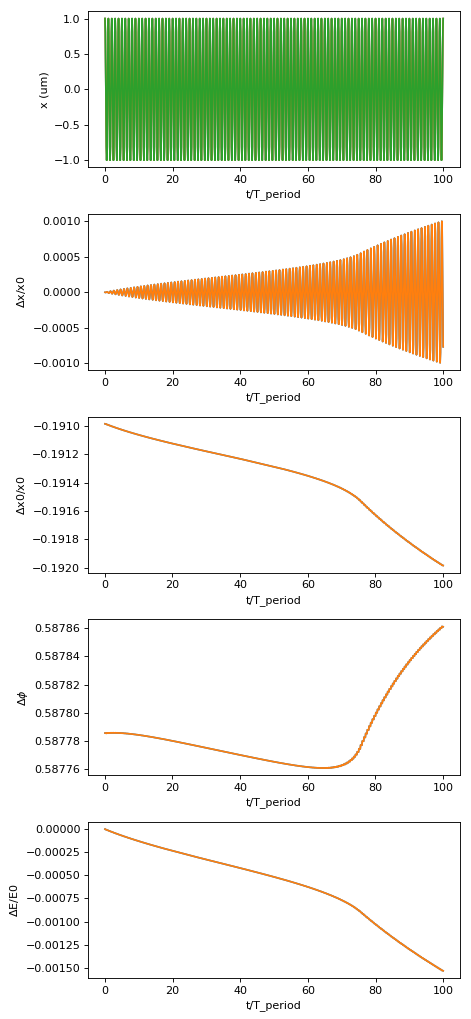

In [8]:
# trajectory solve_ivp simulation
dt = np.double(1e-1*Tperiod)
nperiod = 100
x0, v0 = 1., 0.
phi0 = 0.
E0 = e*sim.analytic(x0,deri=0)
ncycle, nreport = int(nperiod*Tperiod/dt), 1
t_eval = np.linspace(0.,dt*ncycle,ncycle/nreport+1)
trja = exact_x(t_eval,x0,v0,omega)
# position x(t)
trj1, trj2 = [x0], [x0]
# amplitude ratio Δx0/x0
atrj1, atrj2 = [np.nan], [np.nan]
# phase diff Δφ
ptrj1, ptrj2 = [np.nan], [np.nan]
# energy ratio ΔE/E0
etrj1, etrj2 = [0.], [0.]
tr1 = sim.trajectory_RK(x0=x0,v0=v0,qoverm=e/m,dt=dt,nsteps=1,mode='analytic')
tr2 = sim.trajectory_RK(x0=x0,v0=v0,qoverm=e/m,dt=dt,nsteps=1,mode='discrete')
for i in range(ncycle):
    xnew1, xnew2 = next(tr1), next(tr2)
    if i%nreport == 0:
        phase = omega*i*dt
        # position x(t)
        trj1.append(xnew1[1])
        trj2.append(xnew2[1])
        # Δx, Δv
        deltax1 = xnew1[1]-exact_x(i*dt,x0,v0,omega)
        deltax2 = xnew2[1]-exact_x(i*dt,x0,v0,omega)
        deltav1 = xnew1[2]-exact_v(i*dt,x0,v0,omega)
        deltav2 = xnew2[2]-exact_v(i*dt,x0,v0,omega)
        # amplitude ratio Δx0/x0
        atrj1.append(deltax1*np.cos(phase)-deltav1/omega*np.sin(phase))
        atrj2.append(deltax2*np.cos(phase)-deltav2/omega*np.sin(phase))
        # phase diff Δφ
        ptrj1.append(-(deltax1*np.sin(phase)+deltav1/omega*np.cos(phase))/x0)
        ptrj2.append(-(deltax2*np.sin(phase)+deltav2/omega*np.cos(phase))/x0)
        # energy ratio ΔE/E0
        etrj1.append((e*sim.analytic(xnew1[1],deri=0)+1./2*m*xnew1[2]**2-E0)/E0)
        etrj2.append((e*sim.analytic(xnew2[1],deri=0)+1./2*m*xnew2[2]**2-E0)/E0)
# position x(t)
trj1, trj2 = np.array(trj1),np.array(trj2)
# Δx
dtrj1, dtrj2 = (trj1-trja)/x0, (trj2-trja)/x0
dtrj_slope = max(dtrj1,key=abs)/nperiod
# amplitude ratio Δx0/x0
atrj1, atrj2 = np.array(atrj1)/x0, np.array(atrj2)/x0
atrj_slope = max(np.nanmax(atrj1),np.nanmin(atrj1),key=abs)/nperiod
# phase diff Δφ
ptrj1, ptrj2 = np.array(ptrj1), np.array(ptrj2)
ptrj_slope = max(np.nanmax(ptrj1),np.nanmin(ptrj1),key=abs)/nperiod
# energy ratio ΔE/E0
etrj1, etrj2 = np.array(etrj1), np.array(etrj2)
etrj_slope = max(etrj1,key=abs)/nperiod
        
fig, ax = plt.subplots(5,1,gridspec_kw={'hspace':0.3},figsize=(6,16),dpi=80)
ax[0].plot(t_eval/Tperiod,trj1,t_eval/Tperiod,trj2,t_eval/Tperiod,trja)
ax[1].plot(t_eval/Tperiod,dtrj1,t_eval/Tperiod,dtrj2)
ax[2].plot(t_eval/Tperiod,atrj1,t_eval/Tperiod,atrj2)
ax[3].plot(t_eval/Tperiod,ptrj1,t_eval/Tperiod,ptrj2)
ax[4].plot(t_eval/Tperiod,etrj1,t_eval/Tperiod,etrj2)
y_name = ['x (um)',r'$\Delta$x/x0',r'$\Delta$x0/x0',r'$\Delta\phi$',r'$\Delta$E/E0']
for yn, axi in zip(y_name,ax):
    axi.set_xlabel('t/T_period')
    axi.set_ylabel(yn)
dtrj_slope, atrj_slope, ptrj_slope, etrj_slope

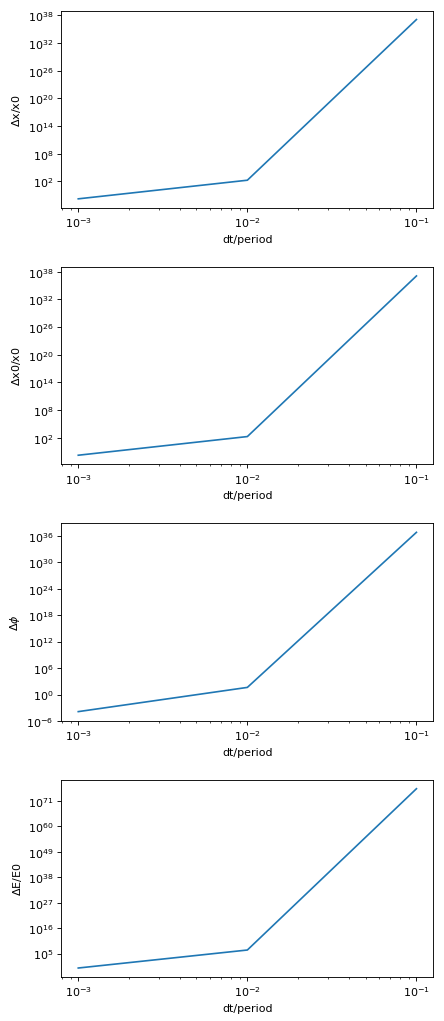

In [6]:
# trajectory euler error as functions of dt, order = 1
timestep = np.array([1e-1,1e-2,1e-3])
delta = [0,0,0,0]
delta[0] = np.array([1.3245972339553714e+37,184.63457768270138,0.016830417299471233])  # Δx
delta[1] = np.array([1.258647467577501e+37,187.6378182165113,0.01683036682727799])  # Δx0
delta[2] = np.array([6.331744825151552e+36,-41.932451719765,0.00013432692333743425])  # Δφ
delta[3] = np.array([1.8558009816374038e+76,3697003.4088647305,0.06198771076803339])  # ΔE
y_name = [r'$\Delta$x/x0',r'$\Delta$x0/x0',r'$\Delta\phi$',r'$\Delta$E/E0']

fig, ax = plt.subplots(4,1,gridspec_kw={'hspace':0.3},figsize=(6,16),dpi=80)
for yn, y, axi in zip(y_name,delta,ax):
    axi.plot(timestep,np.abs(y))
    axi.set_ylabel(yn)
    axi.set_xlabel('dt/period')
    axi.set_yscale('log')
    axi.set_xscale('log')

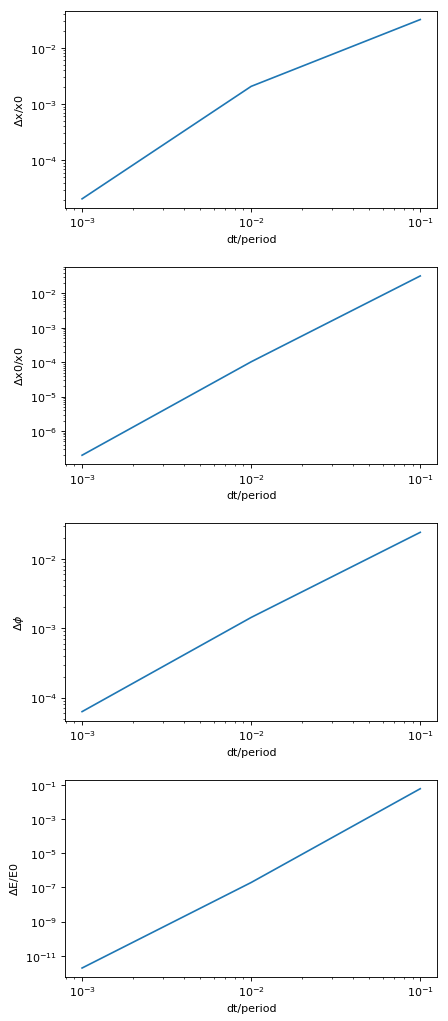

In [7]:
# trajectory euler error as functions of dt, order = 3
timestep = np.array([1e-1,1e-2,1e-3])
delta = [0,0,0,0]
delta[0] = np.array([0.03166528008336468,-0.0020569457952796903,-2.0619037280856693e-05])  # Δx
delta[1] = np.array([-0.03237646158000965,-0.00010305355016061816,-1.9739013985886623e-07])  # Δx0
delta[2] = np.array([0.024158358241674387,-0.001432611036137953,6.283123295238265e-05])  # Δφ
delta[3] = np.array([0.058385383794803875,1.9234118493563762e-07,1.923014447217469e-12])  # ΔE
y_name = [r'$\Delta$x/x0',r'$\Delta$x0/x0',r'$\Delta\phi$',r'$\Delta$E/E0']

fig, ax = plt.subplots(4,1,gridspec_kw={'hspace':0.3},figsize=(6,16),dpi=80)
for yn, y, axi in zip(y_name,delta,ax):
    axi.plot(timestep,np.abs(y))
    axi.set_ylabel(yn)
    axi.set_xlabel('dt/period')
    axi.set_yscale('log')
    axi.set_xscale('log')

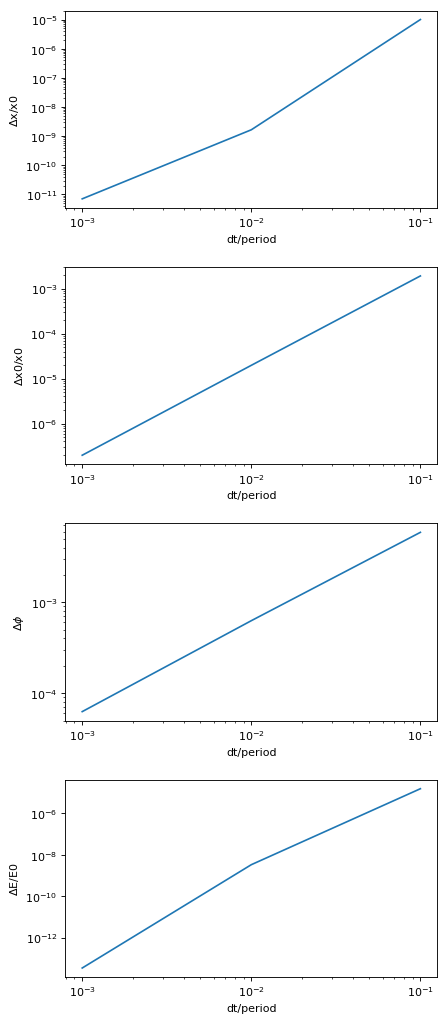

In [5]:
# trajectory solve_ivp RK45 error as functions of dt
timestep = np.array([1e-1,1e-2,1e-3])
delta = [0,0,0,0]
delta[0] = np.array([1.0006116126516362e-05,1.650258378838032e-09,7.053328979905738e-12])  # Δx
delta[1] = np.array([-0.0019198587041952004,-1.9734372642062957e-05,-1.9739150038912057e-07])  # Δx0
delta[2] = np.array([0.005878612790173523,0.0006279052701694479,6.283144678313712e-05])  # Δφ
delta[3] = np.array([-1.532524931394102e-05,-3.2979069684858833e-09,-3.395224220946326e-14])  # ΔE
y_name = [r'$\Delta$x/x0',r'$\Delta$x0/x0',r'$\Delta\phi$',r'$\Delta$E/E0']

fig, ax = plt.subplots(4,1,gridspec_kw={'hspace':0.3},figsize=(6,16),dpi=80)
for yn, y, axi in zip(y_name,delta,ax):
    axi.plot(timestep,np.abs(y))
    axi.set_ylabel(yn)
    axi.set_xlabel('dt/period')
    axi.set_yscale('log')
    axi.set_xscale('log')

In [9]:
# speed test
from time import time
dt = np.double(1e-3*Tperiod)
ncycle = int(100*Tperiod/dt)
order = 3
tr1e = sim.trajectory_euler(x0=x0,v0=v0,qoverm=e/m,dt=dt,nsteps=1,mode='analytic',itern=order)
tr2e = sim.trajectory_euler(x0=x0,v0=v0,qoverm=e/m,dt=dt,nsteps=1,mode='discrete',itern=order)
tr1rk = sim.trajectory_RK(x0=x0,v0=v0,qoverm=e/m,dt=dt,nsteps=1,mode='analytic')
tr2rk = sim.trajectory_RK(x0=x0,v0=v0,qoverm=e/m,dt=dt,nsteps=1,mode='discrete')

trjs = [tr1e,tr2e,tr1rk,tr2rk]

t0 = time()
ti = []
for tr in trjs:
    for ii in range(ncycle):
        xnew = next(tr)
    ti.append(time())
ti = np.array(ti)-t0
print(ti)

[ 0.5708282   4.28382468 18.10510707 41.1039381 ]


/home/wwc/anaconda3/envs/ele36/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


2.051568385598969e-05 1.9230084191690364e-12


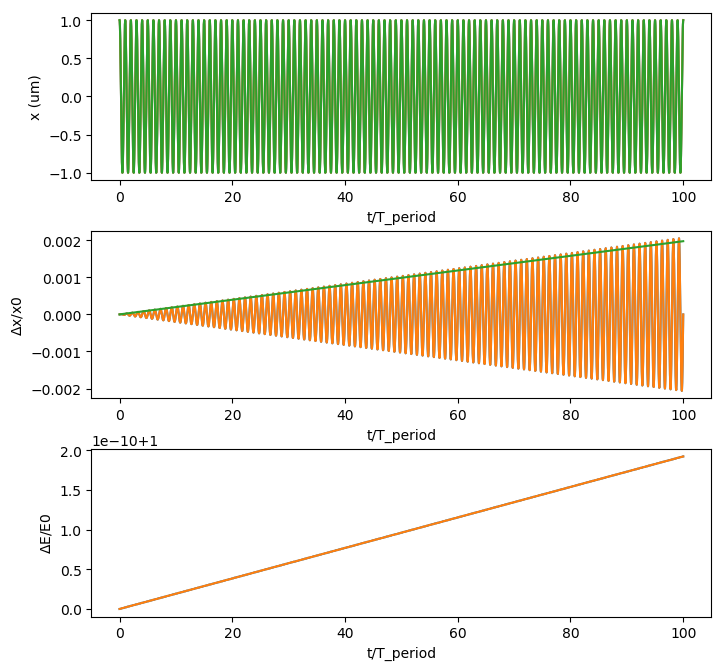

In [24]:
# trajectory euler simulation
dt = np.double(1e-3*Tperiod)
nperiod = 100
order = 3
x0, v0 = 1., 0.
E0 = e*sim.analytic(x0,deri=0)
ncycle, nreport = int(nperiod*Tperiod/dt), 1
t_eval = np.linspace(0.,dt*ncycle,ncycle/nreport+1)
trja = exact_sol(t_eval,x0,v0,2*np.pi/Tperiod)
trj1, trj2 = [x0], [x0]
# energy ratio
etrj1, etrj2 = [1.], [1.]
tr1 = sim.trajectory_euler(x0=x0,v0=v0,qoverm=e/m,dt=dt,nsteps=1,mode='analytic',itern=order)
tr2 = sim.trajectory_euler(x0=x0,v0=v0,qoverm=e/m,dt=dt,nsteps=1,mode='discrete',itern=order)
for i in range(ncycle):
    xnew1, xnew2 = next(tr1), next(tr2)
    if i%nreport == 0:
        trj1.append(xnew1[1])
        trj2.append(xnew2[1])
        etrj1.append((e*sim.analytic(xnew1[1],deri=0)+1./2*m*xnew1[2]**2)/E0)
        etrj2.append((e*sim.analytic(xnew2[1],deri=0)+1./2*m*xnew2[2]**2)/E0)
trj1, trj2 = np.array(trj1),np.array(trj2)
dtrja = (omega*dt)**2*t_eval/2/x0
dtrj1, dtrj2 = (trj1-trja)/x0, (trj2-trja)/x0
dtrj_slope = (np.max(dtrj1)-dtrj1[0])/nperiod
etrj_slope = (etrj1[-1]-etrj1[0])/nperiod
        
fig, ax = plt.subplots(3,1,gridspec_kw={'hspace':0.3},figsize=(8,8),dpi=100)
ax[0].plot(t_eval/Tperiod,trj1,t_eval/Tperiod,trj2,t_eval/Tperiod,trja)
ax[1].plot(t_eval/Tperiod,dtrj1,t_eval/Tperiod,dtrj2,t_eval/Tperiod,dtrja)
ax[2].plot(t_eval/Tperiod,etrj1,t_eval/Tperiod,etrj2)
y_name = ['x (um)',r'$\Delta$x/x0',r'$\Delta$E/E0']
for yn, axi in zip(y_name,ax):
    axi.set_xlabel('t/T_period')
    axi.set_ylabel(yn)
print(dtrj_slope,etrj_slope)